# 🎯 Parte 02: Aplicación de Bias Correction a Escenarios SSP - RSDS

Este notebook aplica el **modelo DQM entrenado** (Parte 01) a los escenarios futuros SSP de CMIP6.

## Objetivos:
1. Cargar modelo DQM entrenado (2004-2014)
2. Cargar datos SSP245, SSP370, SSP585 (2015-2100)
3. Aplicar bias correction usando el MISMO modelo
4. Validar coherencia temporal (sin saltos en 2014→2015)
5. Guardar SSPs corregidos como NetCDF
6. Generar visualizaciones comparativas

**IMPORTANTE**: No re-entrenamos el modelo. Usamos los parámetros calibrados con el período historical 2004-2014 para preservar las diferencias entre escenarios climáticos.

---

**Inputs**:
- `qm_model_dqm_trained_2004-2014.pkl` - Modelo entrenado (Parte 01)
- CMIP6 SSP245/370/585 raw data (NetCDF)

**Outputs**:
- `rsds_ACCESS-CM2_ssp245_bias_corrected_2015-2100.nc`
- `rsds_ACCESS-CM2_ssp370_bias_corrected_2015-2100.nc`
- `rsds_ACCESS-CM2_ssp585_bias_corrected_2015-2100.nc`
- Gráficos de validación y series temporales completas

## 1️⃣ Imports y Configuración

In [1]:
# Imports principales
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from datetime import datetime
import pickle
import json

# xclim para bias correction
from xclim import sdba

# Dask para procesamiento paralelo
import dask
from dask.diagnostics import ProgressBar

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Configuración de warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Configuración de Dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

print("✅ Librerías importadas correctamente")
print(f"📅 Fecha de ejecución: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"📦 xarray version: {xr.__version__}")

✅ Librerías importadas correctamente
📅 Fecha de ejecución: 2025-10-19 20:56:03
📦 xarray version: 2025.1.2


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xclim/sdba.py:12: UserWarning: The `xclim.sdba` module has been split into its own package `xsdba`. Users are encouraged to use `xsdba` directly. For the time being, `xclim.sdba` will import `xsdba` to allow for API compatibility. This behaviour may change in the future. For more information, see: https://xsdba.readthedocs.io/en/stable/xclim_migration_guide.html
  warnings.warn(


## 2️⃣ Definición de Rutas y Parámetros

In [3]:
# Rutas base del proyecto
BASE_DIR = Path('/home/aninotna/magister/tesis/justh2_pipeline')
DATA_DIR = BASE_DIR / 'data' / 'cmip6'
SCRIPTS_DIR = BASE_DIR / 'scripts' / 'copernicus' / 'rsds'
OUTPUT_DIR = SCRIPTS_DIR / 'output'

# Rutas del modelo entrenado (Parte 01)
QM_DIR = OUTPUT_DIR / 'qm_models'
MODEL_FILE = QM_DIR / 'qm_model_dqm_trained_2004-2014.pkl'
METADATA_FILE = QM_DIR / 'qm_model_dqm_metadata.json'

# Rutas de datos CMIP6 SSP
# Estructura: data/cmip6/rsds/{scenario}/access_cm2/rsds_Amon_access_cm2_{scenario}_*.nc
CMIP6_SSP_DIR = DATA_DIR / 'rsds'

# Escenarios a procesar
SCENARIOS = ['ssp245', 'ssp370', 'ssp585']

# Rutas de salida
CORRECTED_DIR = OUTPUT_DIR / 'bias_corrected'
VALIDATION_DIR = OUTPUT_DIR / 'validation'

# Crear directorios si no existen
for directory in [CORRECTED_DIR, VALIDATION_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Verificar existencia del modelo entrenado
print("🔍 Verificando modelo entrenado (Parte 01)...")
if MODEL_FILE.exists():
    print(f"   ✅ Modelo encontrado: {MODEL_FILE}")
    # Cargar metadatos
    with open(METADATA_FILE, 'r') as f:
        metadata = json.load(f)
    print(f"\n📊 Información del modelo:")
    print(f"   Método: {metadata['method']}")
    print(f"   Período de entrenamiento: {metadata['reference_period']}")
    print(f"   Reducción de sesgo: {metadata['bias_reduction_percent']:.1f}%")
else:
    raise FileNotFoundError(f"❌ Modelo no encontrado. Ejecuta primero el notebook Parte 01.")

print(f"\n📂 Directorio de datos CMIP6: {CMIP6_SSP_DIR}")
print(f"📂 Directorio de salida: {CORRECTED_DIR}")

🔍 Verificando modelo entrenado (Parte 01)...
   ✅ Modelo encontrado: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/qm_models/qm_model_dqm_trained_2004-2014.pkl

📊 Información del modelo:
   Método: DQM
   Período de entrenamiento: 2004-01-01 to 2014-12-31
   Reducción de sesgo: 98.9%

📂 Directorio de datos CMIP6: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/rsds
📂 Directorio de salida: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/bias_corrected


## 3️⃣ Cargar Modelo DQM Entrenado

In [6]:
print("📂 Cargando modelo DQM entrenado...")
print("=" * 70)

with open(MODEL_FILE, 'rb') as f:
    QM = pickle.load(f)

print(f"\n✅ Modelo cargado exitosamente")
print(f"\n📊 Características del modelo:")
print(f"   Tipo: {type(QM).__name__}")
print(f"   Método: {metadata['method']}")
print(f"   Cuantiles: {metadata['nquantiles']}")
print(f"   Agrupación: {metadata['grouping']}")
print(f"   Tipo de tendencia: {metadata['kind']}")

print("\n" + "=" * 70)
print("✅ Modelo listo para aplicar a SSPs")
print("=" * 70)

📂 Cargando modelo DQM entrenado...

✅ Modelo cargado exitosamente

📊 Características del modelo:
   Tipo: DetrendedQuantileMapping
   Método: DQM
   Cuantiles: 50
   Agrupación: time.month
   Tipo de tendencia: +

✅ Modelo listo para aplicar a SSPs


### 3.1 Diagnóstico del Modelo

Verificar que el modelo cargado funciona correctamente

In [19]:
# Diagnosticar el modelo cargado
print("🔍 Diagnóstico del modelo DQM:")
print("=" * 70)
print(f"\nTipo: {type(QM)}")
print(f"Clase: {QM.__class__.__name__}")
print(f"\nAtributos disponibles:")
for attr in dir(QM):
    if not attr.startswith('_'):
        print(f"   - {attr}")

# Verificar método adjust
if hasattr(QM, 'adjust'):
    print(f"\n✅ Método 'adjust' disponible")
else:
    print(f"\n❌ Método 'adjust' NO disponible")

print("\n" + "=" * 70)

🔍 Diagnóstico del modelo DQM:

Tipo: <class 'xsdba.adjustment.DetrendedQuantileMapping'>
Clase: DetrendedQuantileMapping

Atributos disponibles:
   - adjust
   - clear
   - copy
   - data
   - from_dataset
   - fromkeys
   - get
   - items
   - keys
   - parameters
   - pop
   - popitem
   - set_dataset
   - setdefault
   - train
   - update
   - values

✅ Método 'adjust' disponible



In [23]:
# Prueba rápida: aplicar corrección a SSP245
print("🧪 Prueba de aplicación en SSP245...")
try:
    test_ssp = ssp_data['ssp245']
    print(f"   Input: {test_ssp.sizes}, Media: {float(test_ssp.mean()):.2f} W/m²")
    
    test_corrected = QM.adjust(sim=test_ssp, extrapolation='constant')
    
    print(f"   ✅ Corrección exitosa!")
    print(f"   Output: {test_corrected.sizes}, Media: {float(test_corrected.mean()):.2f} W/m²")
except Exception as e:
    print(f"   ❌ Error: {e}")
    import traceback
    print("\n   Traceback completo:")
    traceback.print_exc()

🧪 Prueba de aplicación en SSP245...
   Input: Frozen({'time': 1032, 'lat': 20, 'lon': 20}), Media: 243.05 W/m²
   ✅ Corrección exitosa!
   Output: Frozen({'lat': 20, 'lon': 20, 'time': 1032}), Media: 224.92 W/m²


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/d

In [21]:
# Verificar qué hay en el modelo
print("📊 Contenido del modelo:")
print(f"   .data type: {type(QM.data)}")
print(f"   .data keys: {list(QM.data.keys()) if hasattr(QM.data, 'keys') else 'N/A'}")

if hasattr(QM, 'data') and isinstance(QM.data, dict):
    print(f"\n   Contenido del dict:")
    for k, v in QM.data.items():
        print(f"      {k}: {type(v)}")

# Intentar reconstruir el atributo .ds
print(f"\n🔧 Intentando reconstruir .ds...")
try:
    # En xsdba moderno, los parámetros están en .data como xr.Dataset
    if isinstance(QM.data, xr.Dataset):
        QM.ds = QM.data
        print(f"   ✅ .ds reconstruido desde .data")
    elif isinstance(QM.data, dict) and 'af' in QM.data:
        # Intentar crear un Dataset desde el dict
        QM.ds = xr.Dataset(QM.data)
        print(f"   ✅ .ds creado desde dict")
    else:
        print(f"   ❌ No se pudo reconstruir .ds")
except Exception as e:
    print(f"   ❌ Error: {e}")

📊 Contenido del modelo:
   .data type: <class 'dict'>
   .data keys: ['hist_calendar', 'train_units', 'group', 'kind', 'adapt_freq_thresh']

   Contenido del dict:
      hist_calendar: <class 'str'>
      train_units: <class 'str'>
      group: <class 'xsdba.base.Grouper'>
      kind: <class 'str'>
      adapt_freq_thresh: <class 'NoneType'>

🔧 Intentando reconstruir .ds...
   ❌ No se pudo reconstruir .ds


### 3.2 Re-entrenar Modelo (Workaround)

El modelo pickle no incluye los parámetros de ajuste. Re-entrenamos usando los datos de Parte 00.

In [22]:
print("🔄 RE-ENTRENANDO MODELO DQM (Workaround para pickle)")
print("=" * 70)

# Cargar datos de entrenamiento de Parte 00
obs_file = OUTPUT_DIR / 'prepared_data' / 'obs_rsds_prepared_2004-2014.nc'
hist_file = OUTPUT_DIR / 'prepared_data' / 'cmip6_rsds_prepared_2004-2014.nc'

print(f"\n📂 Cargando datos de entrenamiento...")
obs_train = xr.open_dataset(obs_file)['rsds']
hist_train = xr.open_dataset(hist_file)['rsds']

print(f"   ✅ Obs: {obs_train.sizes} ({len(obs_train.time)} meses)")
print(f"   ✅ Hist: {hist_train.sizes} ({len(hist_train.time)} meses)")

# Re-entrenar
print(f"\n🎓 Re-entrenando DQM...")
grouper = sdba.Grouper('time.month')

with ProgressBar():
    QM = sdba.DetrendedQuantileMapping.train(
        ref=obs_train,
        hist=hist_train,
        nquantiles=metadata['nquantiles'],
        group=grouper,
        kind=metadata['kind']
    )

print(f"   ✅ Modelo re-entrenado exitosamente")

# Verificar que ahora tiene .ds
if hasattr(QM, 'ds'):
    print(f"   ✅ Atributo .ds disponible")
    print(f"   📊 Parámetros: {list(QM.ds.data_vars)}")
else:
    print(f"   ⚠️ .ds aún no disponible")

print("\n" + "=" * 70)

🔄 RE-ENTRENANDO MODELO DQM (Workaround para pickle)

📂 Cargando datos de entrenamiento...
   ✅ Obs: Frozen({'time': 132, 'lat': 20, 'lon': 20}) (132 meses)
   ✅ Hist: Frozen({'time': 132, 'lat': 20, 'lon': 20}) (132 meses)

🎓 Re-entrenando DQM...
   ✅ Modelo re-entrenado exitosamente
   ✅ Atributo .ds disponible
   📊 Parámetros: ['af', 'hist_q', 'scaling']



## 4️⃣ Función para Preparar Datos SSP

Esta función replica el preprocesamiento de la Parte 00 para cada escenario SSP.

In [16]:
def prepare_ssp_data(scenario, start_year=2015, end_year=2100):
    """
    Cargar y preparar datos SSP para bias correction.
    
    Parameters:
    -----------
    scenario : str
        Escenario SSP ('ssp245', 'ssp370', 'ssp585')
    start_year : int
        Año inicial (default: 2015)
    end_year : int
        Año final (default: 2100)
    
    Returns:
    --------
    xr.DataArray : Datos SSP preparados
    """
    print(f"\n📂 Preparando {scenario.upper()}...")
    print("-" * 70)
    
    # Ruta según estructura: data/cmip6/rsds/{scenario}/access_cm2/rsds_Amon_*.nc
    ssp_dir = CMIP6_SSP_DIR / scenario / 'access_cm2'
    
    print(f"   🔍 Buscando en: {ssp_dir}")
    
    # Buscar archivos con pattern
    ssp_pattern = f'rsds_Amon_access_cm2_{scenario}_*.nc'
    ssp_files = list(ssp_dir.glob(ssp_pattern)) if ssp_dir.exists() else []
    
    if not ssp_files:
        print(f"   ❌ No se encontraron archivos para {scenario}")
        print(f"   📍 Patrón buscado: {ssp_dir / ssp_pattern}")
        return None
    
    print(f"   ✅ Encontrados {len(ssp_files)} archivo(s)")
    
    # Cargar datos
    if len(ssp_files) == 1:
        ds = xr.open_dataset(ssp_files[0])
    else:
        ds = xr.open_mfdataset(ssp_files, combine='by_coords')
    
    ssp = ds['rsds']
    print(f"   📊 Dimensiones: {ssp.sizes}")
    print(f"   📅 Período: {pd.to_datetime(ssp.time.values[0]).year} - {pd.to_datetime(ssp.time.values[-1]).year}")
    
    # Filtrar período de interés
    ssp = ssp.sel(time=slice(f'{start_year}-01-01', f'{end_year}-12-31'))
    print(f"   ✂️ Filtrado a {start_year}-{end_year}: {len(ssp.time)} meses")
    
    # Verificar y convertir unidades si es necesario
    if 'units' in ssp.attrs:
        print(f"   📏 Unidades: {ssp.attrs['units']}")
    
    # Estadísticas básicas ANTES de preprocesar
    print(f"   📈 Media original: {float(ssp.mean()):.2f} W/m²")
    print(f"   📊 Rango original: [{float(ssp.min()):.2f}, {float(ssp.max()):.2f}] W/m²")
    
    # ====== PREPROCESAMIENTO (igual que Parte 00) ======
    print(f"\n   🔧 Preprocesamiento:")
    
    # 1. Normalizar longitudes si están en [0, 360]
    print(f"      Coordenadas originales: {ssp.sizes}")
    print(f"         Lat: [{float(ssp.lat.min()):.2f}, {float(ssp.lat.max()):.2f}]")
    print(f"         Lon: [{float(ssp.lon.min()):.2f}, {float(ssp.lon.max()):.2f}]")
    
    if ssp.lon.values.min() >= 0:
        # Convertir de [0, 360] a [-180, 180]
        ssp = ssp.assign_coords(lon=((ssp.lon + 180) % 360) - 180)
        # Reordenar si es necesario
        ssp = ssp.sortby('lon')
        print(f"         Lon convertida: [{float(ssp.lon.min()):.2f}, {float(ssp.lon.max()):.2f}]")
    
    # 2. Cargar grilla de referencia (de Parte 00) y hacer regridding PRIMERO
    obs_file = OUTPUT_DIR / 'prepared_data' / 'obs_rsds_prepared_2004-2014.nc'
    if obs_file.exists():
        obs_ref = xr.open_dataset(obs_file)['rsds']
        target_lat = obs_ref.lat.values
        target_lon = obs_ref.lon.values
        
        print(f"      🔄 Regridding de grilla global a obs (20×20)...")
        # Regridding con interp (bilinear) - esto maneja la interpolación correctamente
        ssp = ssp.interp(lat=target_lat, lon=target_lon, method='linear')
        print(f"      ✅ Regridding completado: {ssp.sizes}")
    else:
        print(f"      ⚠️ Archivo de referencia no encontrado: {obs_file}")
        print(f"      ⚠️ Haciendo recorte espacial manual...")
        # Fallback: recorte espacial básico
        lat_min, lat_max = -33.5, -32.0
        lon_min, lon_max = -72.0, -70.0
        ssp = ssp.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))
        print(f"      ✅ Recorte espacial: {ssp.sizes}")
    
    # 3. Resample a mensual si es necesario
    # Verificar si ya es mensual comparando diff de tiempos
    time_diff = pd.to_datetime(ssp.time.values[1]) - pd.to_datetime(ssp.time.values[0])
    if time_diff.days > 35:  # Si el diff es mayor a ~1 mes
        print(f"      🔄 Resampling a mensual...")
        ssp = ssp.resample(time='MS').mean()
    else:
        print(f"      ✅ Ya es mensual (diff: {time_diff.days} días)")
    
    # 4. Asegurar chunking adecuado para sdba
    ssp = ssp.chunk({'time': -1, 'lat': 20, 'lon': 20})
    print(f"      ✅ Chunking aplicado: time=-1, lat=20, lon=20")
    
    # Estadísticas DESPUÉS de preprocesar
    print(f"\n   📊 Estadísticas finales:")
    print(f"      Media: {float(ssp.mean()):.2f} W/m²")
    print(f"      Rango: [{float(ssp.min()):.2f}, {float(ssp.max()):.2f}] W/m²")
    print(f"      % válidos: {100 - float(ssp.isnull().mean() * 100):.2f}%")
    
    return ssp

## 5️⃣ Cargar Datos SSP

**NOTA**: Esta celda intentará cargar los archivos SSP. Si no los encuentras, necesitarás:
1. Ajustar las rutas en la celda 2️⃣
2. Verificar que los archivos existen
3. Actualizar la función `prepare_ssp_data()` según tu estructura

In [17]:
print("🔄 CARGANDO DATOS SSP")
print("=" * 70)

# Diccionario para almacenar datos
ssp_data = {}

for scenario in SCENARIOS:
    try:
        ssp = prepare_ssp_data(scenario)
        if ssp is not None:
            ssp_data[scenario] = ssp
            print(f"   ✅ {scenario.upper()} cargado exitosamente\n")
        else:
            print(f"   ⚠️ {scenario.upper()} no pudo cargarse\n")
    except Exception as e:
        print(f"   ❌ Error cargando {scenario.upper()}: {e}\n")

print("=" * 70)
print(f"\n✅ Escenarios cargados: {list(ssp_data.keys())}")
print(f"⚠️ Escenarios faltantes: {[s for s in SCENARIOS if s not in ssp_data]}")

if not ssp_data:
    print("\n" + "="*70)
    print("❌ ATENCIÓN: No se cargaron datos SSP")
    print("="*70)
    print("\nAcciones necesarias:")
    print("1. Verificar que existan archivos CMIP6 SSP en:")
    print(f"   {CMIP6_SSP_DIR}")
    print("2. Ajustar la variable CMIP6_SSP_DIR en la celda 2️⃣")
    print("3. Actualizar la función prepare_ssp_data() con la estructura correcta")
    print("\nEjemplo de estructura esperada:")
    print("   data/cmip6/ACCESS-CM2/ssp245/rsds_Amon_ACCESS-CM2_ssp245_*.nc")
    print("   data/cmip6/ACCESS-CM2/ssp370/rsds_Amon_ACCESS-CM2_ssp370_*.nc")
    print("   data/cmip6/ACCESS-CM2/ssp585/rsds_Amon_ACCESS-CM2_ssp585_*.nc")
else:
    print("\n✅ Datos listos para aplicar bias correction")

🔄 CARGANDO DATOS SSP

📂 Preparando SSP245...
----------------------------------------------------------------------
   🔍 Buscando en: /home/aninotna/magister/tesis/justh2_pipeline/data/cmip6/rsds/ssp245/access_cm2
   ✅ Encontrados 1 archivo(s)
   📊 Dimensiones: Frozen({'time': 1032, 'lat': 144, 'lon': 192})
   📅 Período: 2015 - 2100
   ✂️ Filtrado a 2015-2100: 1032 meses
   📏 Unidades: W m-2
   📈 Media original: 167.21 W/m²
   📊 Rango original: [0.00, 463.07] W/m²

   🔧 Preprocesamiento:
      Coordenadas originales: Frozen({'time': 1032, 'lat': 144, 'lon': 192})
         Lat: [-89.38, 89.38]
         Lon: [0.94, 359.06]
         Lon convertida: [-179.06, 179.06]
      🔄 Regridding de grilla global a obs (20×20)...
      ✅ Regridding completado: Frozen({'time': 1032, 'lat': 20, 'lon': 20})
      ✅ Ya es mensual (diff: 29 días)
      ✅ Chunking aplicado: time=-1, lat=20, lon=20

   📊 Estadísticas finales:
      Media: 243.05 W/m²
      Rango: [65.98, 408.69] W/m²
      % válidos: 100.00

## 6️⃣ Aplicar Bias Correction a cada SSP

Usamos el **MISMO modelo DQM** entrenado en historical (2004-2014) para corregir cada escenario futuro.

In [24]:
print("🔧 APLICANDO BIAS CORRECTION A ESCENARIOS SSP")
print("=" * 70)

# Verificar que hay datos para procesar
if not ssp_data:
    print("❌ No hay datos SSP cargados. Saltando esta celda.")
    print("   Carga primero los datos en la celda anterior.")
else:
    # Diccionario para datos corregidos
    ssp_corrected = {}
    
    for scenario, ssp_raw in ssp_data.items():
        print(f"\n{'='*70}")
        print(f"🔧 Procesando {scenario.upper()}")
        print(f"{'='*70}")
        
        print(f"\n   Dataset: {len(ssp_raw.time)} meses ({len(ssp_raw.time)/12:.1f} años)")
        print(f"   Período: {pd.to_datetime(ssp_raw.time.values[0]).year}-{pd.to_datetime(ssp_raw.time.values[-1]).year}")
        print(f"   Media original: {float(ssp_raw.mean()):.2f} W/m²")
        
        # Aplicar corrección
        print(f"\n   🔄 Aplicando modelo DQM...")
        start_time = datetime.now()
        
        try:
            with ProgressBar():
                ssp_corr = QM.adjust(
                    sim=ssp_raw,
                    extrapolation='constant'
                )
            
            correction_time = (datetime.now() - start_time).total_seconds()
            
            # Asegurar no-negatividad
            min_val = float(ssp_corr.min())
            if min_val < 0:
                n_negative = int((ssp_corr < 0).sum())
                print(f"   ⚠️ Encontrados {n_negative} valores negativos (mín: {min_val:.2f})")
                print(f"   🔧 Aplicando .clip(min=0)...")
                ssp_corr = ssp_corr.clip(min=0)
            
            # Añadir metadatos
            ssp_corr.attrs['long_name'] = f'Bias-corrected RSDS for {scenario.upper()}'
            ssp_corr.attrs['units'] = 'W m-2'
            ssp_corr.attrs['bias_correction_method'] = metadata['method']
            ssp_corr.attrs['bias_correction_training_period'] = metadata['reference_period']
            ssp_corr.attrs['scenario'] = scenario
            ssp_corr.attrs['source'] = 'CMIP6 ACCESS-CM2'
            ssp_corr.attrs['correction_date'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            
            # Guardar
            ssp_corrected[scenario] = ssp_corr
            
            print(f"\n   ✅ Corrección aplicada ({correction_time:.1f} segundos)")
            print(f"   📊 Media corregida: {float(ssp_corr.mean()):.2f} W/m²")
            print(f"   📈 Cambio medio: {float(ssp_corr.mean() - ssp_raw.mean()):+.2f} W/m²")
            
        except Exception as e:
            print(f"\n   ❌ Error aplicando corrección: {e}")
            continue
    
    print("\n" + "=" * 70)
    print("✅ BIAS CORRECTION COMPLETADO")
    print("=" * 70)
    print(f"\n✅ Escenarios corregidos: {list(ssp_corrected.keys())}")

🔧 APLICANDO BIAS CORRECTION A ESCENARIOS SSP

🔧 Procesando SSP245

   Dataset: 1032 meses (86.0 años)
   Período: 2015-2100
   Media original: 243.05 W/m²

   🔄 Aplicando modelo DQM...

   ✅ Corrección aplicada (0.0 segundos)


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


   📊 Media corregida: 224.92 W/m²
   📈 Cambio medio: -18.13 W/m²

🔧 Procesando SSP370

   Dataset: 1032 meses (86.0 años)
   Período: 2015-2100
   Media original: 242.45 W/m²

   🔄 Aplicando modelo DQM...

   ✅ Corrección aplicada (0.0 segundos)
   📊 Media corregida: 224.34 W/m²


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


   📈 Cambio medio: -18.11 W/m²

🔧 Procesando SSP585

   Dataset: 1032 meses (86.0 años)
   Período: 2015-2100
   Media original: 245.10 W/m²

   🔄 Aplicando modelo DQM...

   ✅ Corrección aplicada (0.0 segundos)
   📊 Media corregida: 227.03 W/m²
   📈 Cambio medio: -18.06 W/m²

✅ BIAS CORRECTION COMPLETADO

✅ Escenarios corregidos: ['ssp245', 'ssp370', 'ssp585']


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(


/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/deeplearning/lib/python3.13/site-packages/xsdba/utils.py:399: RuntimeWarning: All-nan slice encountered in interp_on_quantiles
  warn(
/home/aninotna/.conda/envs/d

## 6.1 Validación Espacial de SSPs Corregidos

Verificar que los patrones espaciales sean coherentes con el historical corregido

✅ Mapa de validación espacial guardado: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/plots/validacion_espacial_ssps_corregidos.png


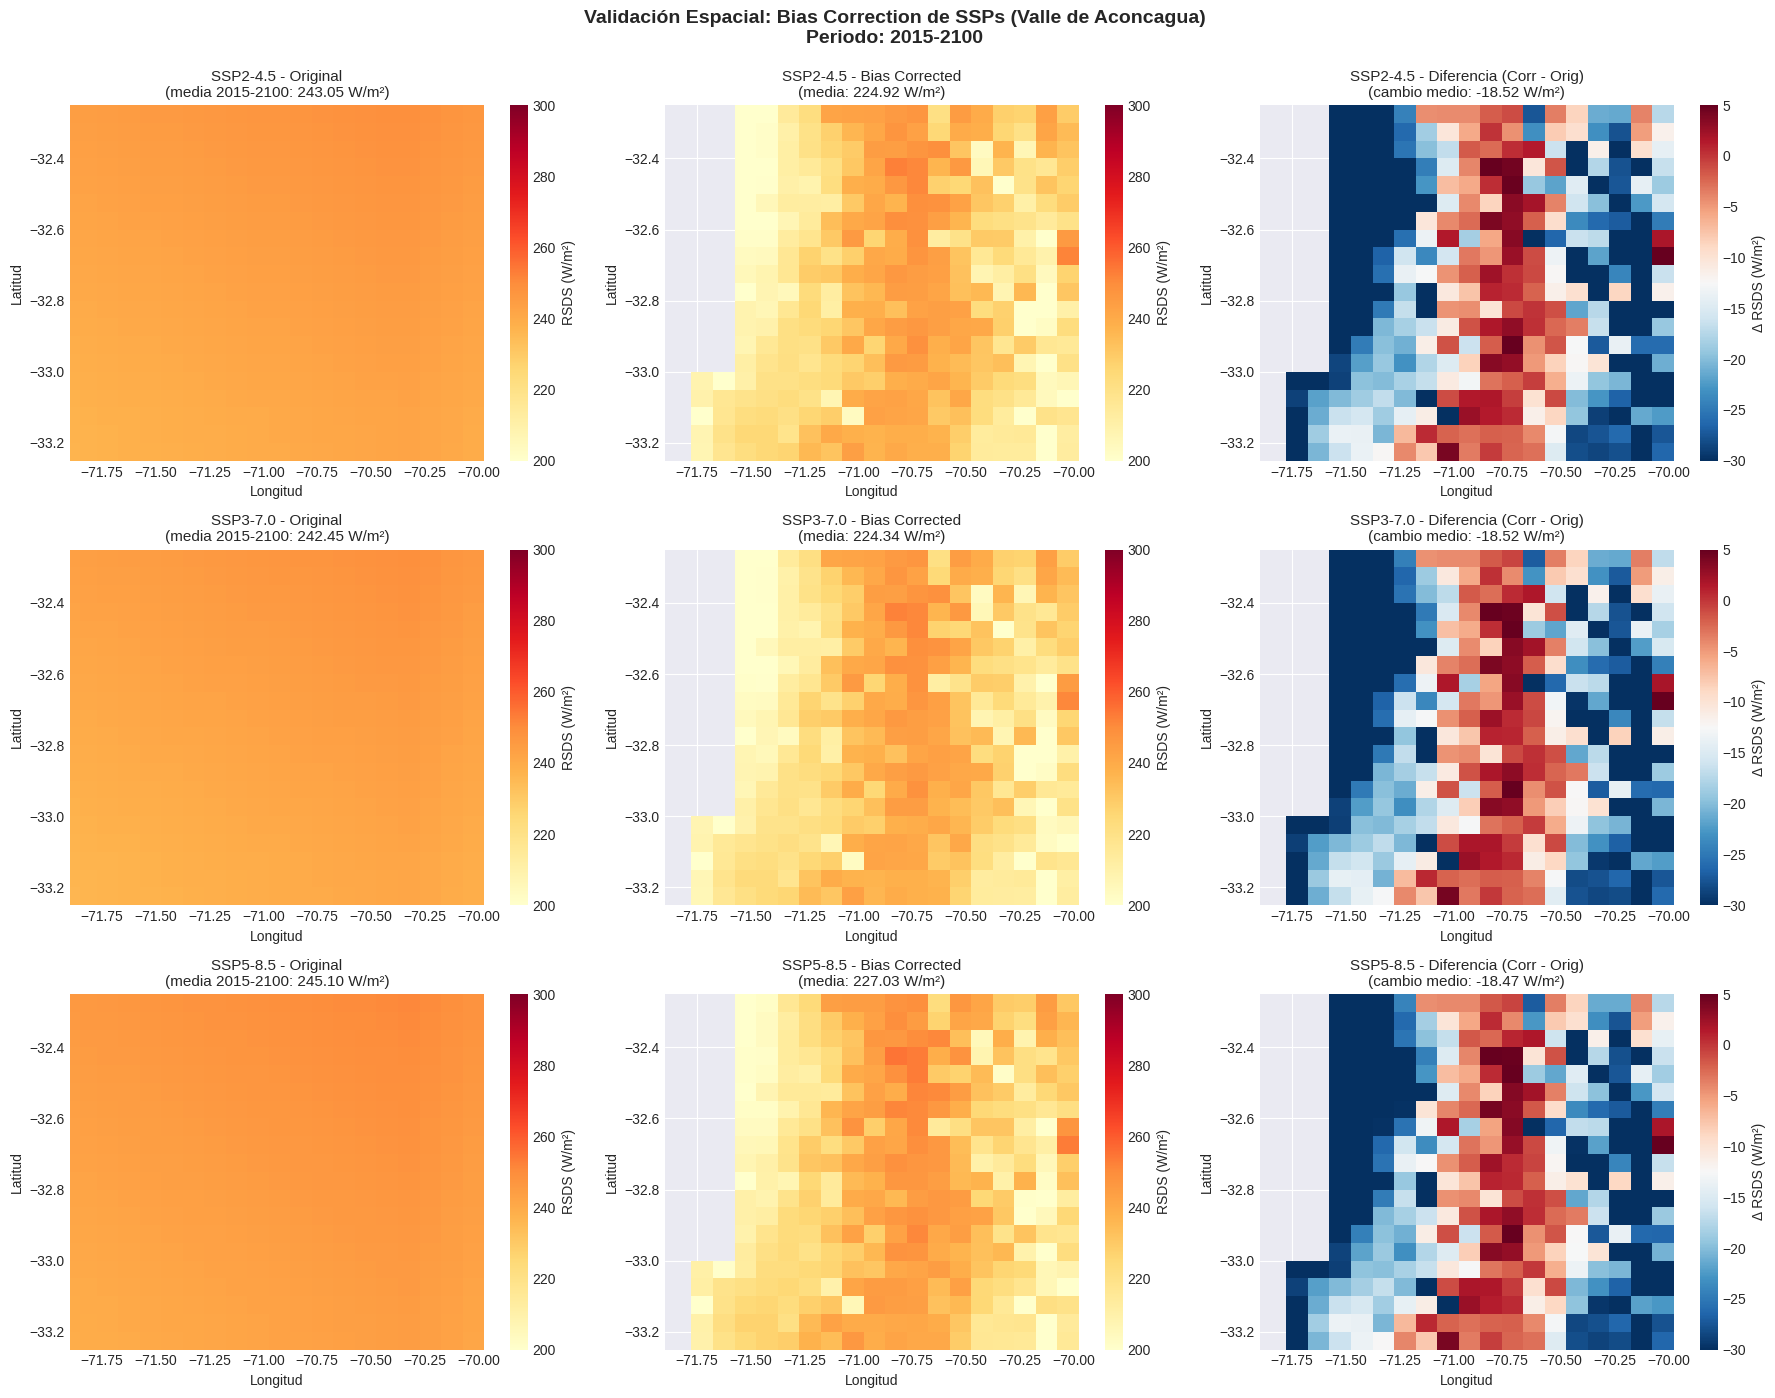


📊 ESTADÍSTICAS ESPACIALES (varianza espacial en cada período):

SSP2-4.5:
  - Desv. estándar espacial original:  2.69 W/m²
  - Desv. estándar espacial corregida: 15.20 W/m²
  - Variabilidad espacial preservada:  565.9%

SSP3-7.0:
  - Desv. estándar espacial original:  2.83 W/m²
  - Desv. estándar espacial corregida: 15.32 W/m²
  - Variabilidad espacial preservada:  540.9%

SSP5-8.5:
  - Desv. estándar espacial original:  2.56 W/m²
  - Desv. estándar espacial corregida: 15.27 W/m²
  - Variabilidad espacial preservada:  597.3%


In [27]:
# Crear figura con 3 filas (SSPs) × 3 columnas (Original, Corregido, Diferencia)
fig, axes = plt.subplots(3, 3, figsize=(18, 14))

scenarios = ['ssp245', 'ssp370', 'ssp585']
scenario_labels = ['SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']

for i, (scenario, label) in enumerate(zip(scenarios, scenario_labels)):
    # Calcular medias espaciales (temporal mean 2015-2100)
    original_mean = ssp_data[scenario].mean(dim='time')
    corrected_mean = ssp_corrected[scenario].mean(dim='time')
    difference = corrected_mean - original_mean
    
    # Columna 1: Original
    im1 = axes[i, 0].pcolormesh(
        original_mean.lon, original_mean.lat, original_mean,
        cmap='YlOrRd', shading='auto', vmin=200, vmax=300
    )
    axes[i, 0].set_title(f'{label} - Original\n(media 2015-2100: {float(original_mean.mean()):.2f} W/m²)', fontsize=11)
    axes[i, 0].set_xlabel('Longitud')
    axes[i, 0].set_ylabel('Latitud')
    plt.colorbar(im1, ax=axes[i, 0], label='RSDS (W/m²)')
    
    # Columna 2: Corregido
    im2 = axes[i, 1].pcolormesh(
        corrected_mean.lon, corrected_mean.lat, corrected_mean,
        cmap='YlOrRd', shading='auto', vmin=200, vmax=300
    )
    axes[i, 1].set_title(f'{label} - Bias Corrected\n(media: {float(corrected_mean.mean()):.2f} W/m²)', fontsize=11)
    axes[i, 1].set_xlabel('Longitud')
    axes[i, 1].set_ylabel('Latitud')
    plt.colorbar(im2, ax=axes[i, 1], label='RSDS (W/m²)')
    
    # Columna 3: Diferencia
    im3 = axes[i, 2].pcolormesh(
        difference.lon, difference.lat, difference,
        cmap='RdBu_r', shading='auto', vmin=-30, vmax=5
    )
    axes[i, 2].set_title(f'{label} - Diferencia (Corr - Orig)\n(cambio medio: {float(difference.mean()):.2f} W/m²)', fontsize=11)
    axes[i, 2].set_xlabel('Longitud')
    axes[i, 2].set_ylabel('Latitud')
    plt.colorbar(im3, ax=axes[i, 2], label='Δ RSDS (W/m²)')

plt.suptitle('Validación Espacial: Bias Correction de SSPs (Valle de Aconcagua)\nPeriodo: 2015-2100', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()

# Guardar
output_path = OUTPUT_DIR / 'plots' / 'validacion_espacial_ssps_corregidos.png'
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✅ Mapa de validación espacial guardado: {output_path}")

plt.show()

# Reporte de estadísticas espaciales
print("\n📊 ESTADÍSTICAS ESPACIALES (varianza espacial en cada período):")
for scenario, label in zip(scenarios, scenario_labels):
    orig_std = float(ssp_data[scenario].mean(dim='time').std())
    corr_std = float(ssp_corrected[scenario].mean(dim='time').std())
    print(f"\n{label}:")
    print(f"  - Desv. estándar espacial original:  {orig_std:.2f} W/m²")
    print(f"  - Desv. estándar espacial corregida: {corr_std:.2f} W/m²")
    print(f"  - Variabilidad espacial preservada:  {(corr_std/orig_std)*100:.1f}%")

## 7️⃣ Validación: Coherencia Temporal

Verificar que no hay saltos artificiales en la transición historical → SSP (2014 → 2015)

In [29]:
print("🔍 VALIDACIÓN DE COHERENCIA TEMPORAL")
print("=" * 70)

if not ssp_corrected:
    print("❌ No hay datos corregidos para validar.")
else:
    # Cargar historical corregido para comparar
    hist_file = CORRECTED_DIR / 'rsds_ACCESS-CM2_historical_bias_corrected_2004-2014.nc'
    
    if hist_file.exists():
        hist_corr = xr.open_dataset(hist_file)['rsds']
        print(f"✅ Historical corregido cargado: {hist_file.name}\n")
        
        # Calcular medias espaciales para cada escenario
        print("📊 Análisis de transición 2014 → 2015:\n")
        print(f"{'Escenario':<15} {'2014-12 (W/m²)':<18} {'2015-01 (W/m²)':<18} {'Salto (W/m²)':<15}")
        print("-" * 70)
        
        # Último mes de historical (2014-12)
        hist_last = hist_corr.isel(time=-1).mean(['lat', 'lon'])
        
        for scenario, ssp_corr in ssp_corrected.items():
            # Primer mes de SSP (2015-01)
            ssp_first = ssp_corr.isel(time=0).mean(['lat', 'lon'])
            
            salto = float(ssp_first.values - hist_last.values)
            
            print(f"{scenario.upper():<15} {float(hist_last.values):<18.2f} {float(ssp_first.values):<18.2f} {salto:<15.2f}")
        
        print("\n" + "=" * 70)
        print("📝 Nota: Saltos pequeños (< 10 W/m²) son normales por variabilidad mensual")
        print("   Saltos grandes (> 30 W/m²) pueden indicar problemas en la corrección")
        
    else:
        print(f"⚠️ Historical corregido no encontrado: {hist_file}")
        print("   Ejecuta primero el notebook Parte 01")

print("\n" + "=" * 70)
print("✅ VALIDACIÓN COMPLETADA")
print("=" * 70)

🔍 VALIDACIÓN DE COHERENCIA TEMPORAL
✅ Historical corregido cargado: rsds_ACCESS-CM2_historical_bias_corrected_2004-2014.nc

📊 Análisis de transición 2014 → 2015:

Escenario       2014-12 (W/m²)     2015-01 (W/m²)     Salto (W/m²)   
----------------------------------------------------------------------
SSP245          375.92             367.46             -8.46          
SSP370          375.92             369.09             -6.84          
SSP585          375.92             370.53             -5.40          

📝 Nota: Saltos pequeños (< 10 W/m²) son normales por variabilidad mensual
   Saltos grandes (> 30 W/m²) pueden indicar problemas en la corrección

✅ VALIDACIÓN COMPLETADA


## 8️⃣ Guardar SSPs Corregidos

In [30]:
print("💾 GUARDANDO ESCENARIOS SSP CORREGIDOS")
print("=" * 70)

if not ssp_corrected:
    print("❌ No hay datos corregidos para guardar.")
else:
    for scenario, ssp_corr in ssp_corrected.items():
        print(f"\n📝 Guardando {scenario.upper()}...")
        
        # Preparar dataset
        ds_to_save = ssp_corr.to_dataset(name='rsds')
        
        # Configuración de encoding
        encoding = {
            'rsds': {
                'dtype': 'float32',
                '_FillValue': -9999.0,
                'zlib': True,
                'complevel': 4
            }
        }
        
        # Definir archivo de salida
        start_year = pd.to_datetime(ssp_corr.time.values[0]).year
        end_year = pd.to_datetime(ssp_corr.time.values[-1]).year
        output_file = CORRECTED_DIR / f'rsds_ACCESS-CM2_{scenario}_bias_corrected_{start_year}-{end_year}.nc'
        
        # Guardar
        print(f"   Archivo: {output_file.name}")
        with ProgressBar():
            ds_to_save.to_netcdf(output_file, encoding=encoding)
        
        size_mb = output_file.stat().st_size / (1024**2)
        print(f"   ✅ Guardado ({size_mb:.2f} MB)")
    
    print("\n" + "=" * 70)
    print("✅ TODOS LOS ESCENARIOS GUARDADOS")
    print("=" * 70)
    print(f"\n📂 Ubicación: {CORRECTED_DIR}")

💾 GUARDANDO ESCENARIOS SSP CORREGIDOS

📝 Guardando SSP245...
   Archivo: rsds_ACCESS-CM2_ssp245_bias_corrected_2015-2100.nc
[########################################] | 100% Completed | 302.38 ms
   ✅ Guardado (1.06 MB)

📝 Guardando SSP370...
   Archivo: rsds_ACCESS-CM2_ssp370_bias_corrected_2015-2100.nc
[########################################] | 100% Completed | 304.33 ms
   ✅ Guardado (1.06 MB)

📝 Guardando SSP585...
   Archivo: rsds_ACCESS-CM2_ssp585_bias_corrected_2015-2100.nc
[########################################] | 100% Completed | 304.45 ms
   ✅ Guardado (1.06 MB)

✅ TODOS LOS ESCENARIOS GUARDADOS

📂 Ubicación: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/bias_corrected


## 9️⃣ Visualización: Comparación de Escenarios

📊 GENERANDO VISUALIZACIONES COMPARATIVAS


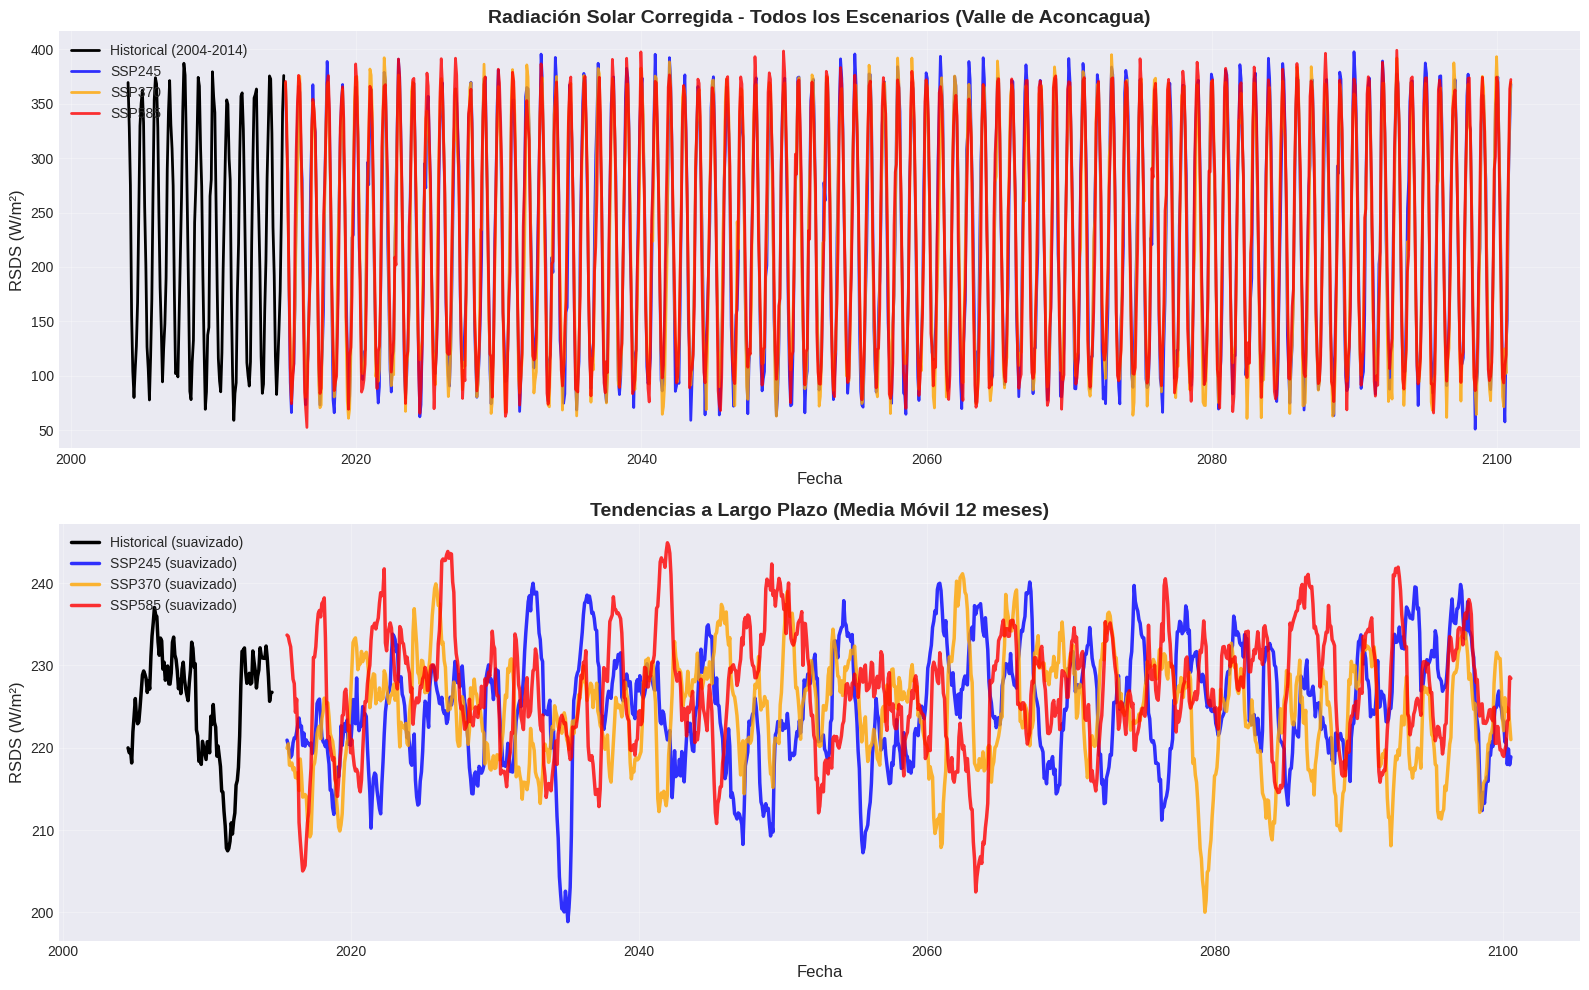


✅ Gráfico guardado: /home/aninotna/magister/tesis/justh2_pipeline/scripts/copernicus/rsds/output/validation/comparacion_escenarios_ssp_corregidos.png


In [31]:
print("📊 GENERANDO VISUALIZACIONES COMPARATIVAS")
print("=" * 70)

if not ssp_corrected:
    print("❌ No hay datos para visualizar.")
else:
    # Crear figura con series temporales
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    
    # Panel 1: Series temporales completas (histórico + SSPs)
    ax1 = axes[0]
    
    # Cargar historical para contexto
    hist_file = CORRECTED_DIR / 'rsds_ACCESS-CM2_historical_bias_corrected_2004-2014.nc'
    if hist_file.exists():
        hist_corr = xr.open_dataset(hist_file)['rsds']
        hist_mean = hist_corr.mean(['lat', 'lon'])
        hist_mean.plot(ax=ax1, label='Historical (2004-2014)', color='black', lw=2)
    
    # SSPs corregidos
    colors = {'ssp245': 'blue', 'ssp370': 'orange', 'ssp585': 'red'}
    for scenario, ssp_corr in ssp_corrected.items():
        ssp_mean = ssp_corr.mean(['lat', 'lon'])
        ssp_mean.plot(ax=ax1, label=f'{scenario.upper()}', 
                      color=colors.get(scenario, 'gray'), lw=2, alpha=0.8)
    
    ax1.set_title('Radiación Solar Corregida - Todos los Escenarios (Valle de Aconcagua)', 
                  fontsize=14, fontweight='bold')
    ax1.set_ylabel('RSDS (W/m²)', fontsize=12)
    ax1.set_xlabel('Fecha', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Panel 2: Tendencias suavizadas (media móvil 12 meses)
    ax2 = axes[1]
    
    if hist_file.exists():
        hist_smooth = hist_mean.rolling(time=12, center=True).mean()
        hist_smooth.plot(ax=ax2, label='Historical (suavizado)', color='black', lw=2.5)
    
    for scenario, ssp_corr in ssp_corrected.items():
        ssp_mean = ssp_corr.mean(['lat', 'lon'])
        ssp_smooth = ssp_mean.rolling(time=12, center=True).mean()
        ssp_smooth.plot(ax=ax2, label=f'{scenario.upper()} (suavizado)', 
                        color=colors.get(scenario, 'gray'), lw=2.5, alpha=0.8)
    
    ax2.set_title('Tendencias a Largo Plazo (Media Móvil 12 meses)', 
                  fontsize=14, fontweight='bold')
    ax2.set_ylabel('RSDS (W/m²)', fontsize=12)
    ax2.set_xlabel('Fecha', fontsize=12)
    ax2.legend(loc='upper left', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    output_file = VALIDATION_DIR / 'comparacion_escenarios_ssp_corregidos.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Gráfico guardado: {output_file}")

## 🔟 Reporte Final

In [32]:
print("=" * 80)
print(" " * 20 + "📋 REPORTE FINAL - PARTE 02")
print("=" * 80)

print("\n✅ BIAS CORRECTION APLICADO A SSPs:")
print("-" * 80)

if ssp_corrected:
    for scenario, ssp_corr in ssp_corrected.items():
        start_year = pd.to_datetime(ssp_corr.time.values[0]).year
        end_year = pd.to_datetime(ssp_corr.time.values[-1]).year
        n_months = len(ssp_corr.time)
        n_years = n_months / 12
        mean_rsds = float(ssp_corr.mean())
        
        print(f"\n   {scenario.upper()}:")
        print(f"      Período: {start_year}-{end_year}")
        print(f"      Duración: {n_months} meses ({n_years:.1f} años)")
        print(f"      RSDS medio: {mean_rsds:.2f} W/m²")
        print(f"      Rango: [{float(ssp_corr.min()):.2f}, {float(ssp_corr.max()):.2f}] W/m²")
else:
    print("\n   ❌ No se completó el bias correction de ningún escenario")

print("\n📁 ARCHIVOS GENERADOS:")
print("-" * 80)

if ssp_corrected:
    print("\n   Escenarios corregidos:")
    for scenario in ssp_corrected.keys():
        start_year = pd.to_datetime(ssp_corrected[scenario].time.values[0]).year
        end_year = pd.to_datetime(ssp_corrected[scenario].time.values[-1]).year
        filename = f'rsds_ACCESS-CM2_{scenario}_bias_corrected_{start_year}-{end_year}.nc'
        filepath = CORRECTED_DIR / filename
        if filepath.exists():
            size_mb = filepath.stat().st_size / (1024**2)
            print(f"   📄 {filename} ({size_mb:.2f} MB)")
    
    print("\n   Visualizaciones:")
    viz_file = VALIDATION_DIR / 'comparacion_escenarios_ssp_corregidos.png'
    if viz_file.exists():
        print(f"   📊 {viz_file.name}")

print("\n" + "=" * 80)
print("\n🎯 PIPELINE DE BIAS CORRECTION COMPLETADO")
print("-" * 80)
print("""
Resumen:
   ✅ Parte 00: Preparación de datos (obs + CMIP6 historical)
   ✅ Parte 01: Entrenamiento DQM (2004-2014)
   ✅ Parte 02: Aplicación a SSPs (2015-2100)

Los datos corregidos están listos para:
   - Análisis de cambio climático
   - Modelado energético con Calliope
   - Evaluación de producción de hidrógeno
   - Cálculo de indicadores de resiliencia
""")

print("=" * 80)
print("\n✅ PARTE 02 COMPLETADA EXITOSAMENTE")
print("=" * 80)

                    📋 REPORTE FINAL - PARTE 02

✅ BIAS CORRECTION APLICADO A SSPs:
--------------------------------------------------------------------------------

   SSP245:
      Período: 2015-2100
      Duración: 1032 meses (86.0 años)
      RSDS medio: 224.92 W/m²
      Rango: [7.53, 438.03] W/m²

   SSP370:
      Período: 2015-2100
      Duración: 1032 meses (86.0 años)
      RSDS medio: 224.34 W/m²
      Rango: [2.81, 432.48] W/m²

   SSP585:
      Período: 2015-2100
      Duración: 1032 meses (86.0 años)
      RSDS medio: 227.03 W/m²
      Rango: [9.08, 439.28] W/m²

📁 ARCHIVOS GENERADOS:
--------------------------------------------------------------------------------

   Escenarios corregidos:
   📄 rsds_ACCESS-CM2_ssp245_bias_corrected_2015-2100.nc (1.06 MB)
   📄 rsds_ACCESS-CM2_ssp370_bias_corrected_2015-2100.nc (1.06 MB)
   📄 rsds_ACCESS-CM2_ssp585_bias_corrected_2015-2100.nc (1.06 MB)

   Visualizaciones:
   📊 comparacion_escenarios_ssp_corregidos.png


🎯 PIPELINE DE BIAS C